# VERSAO FINAL


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

workdir_path = '/content/drive/My Drive/PUC/PROJ/'  # Inserir o local da pasta onde estão os arquivos de entrada (treino e teste)
import os
os.chdir(workdir_path)
import sys
sys.path.append(workdir_path)

Mounted at /content/drive


In [ ]:
%matplotlib inline

#import keras
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

import Leitura as leitura
import matplotlib.pyplot as plt
from scipy.io import loadmat
import math, pandas as pd, numpy as np, seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning,UserWarning))

In [ ]:
#arq_vib = r'D:\Diogo\PUC\BI Master\12.PROJ\Scripts\DadosVib\{}_Spectra.csv'
arq_vib = r'DadosVib/{}_{}.csv'
instalacoes = ['Itarare', 'TEFRAN', 'TEDUT', 'ESPAT','Itajai','TEPAR']
pontos = ['1H','1V','2H','2V','3H','3V','4H','4V']

#**Introdução**

#**Spectro 401 pontos (velocidade)**

## Carrega dados

In [ ]:
tipo = 'Spectra'
canais = [2]
linhas = [401]  #coluna Linhas      pegando apenas grafico de velocidade
n_dados = 401  #posso pegar menos dados para o cepstrum por exemplo
n_pontos = int(len(pontos))

d_spec = leitura.Dados(arq_vib, instalacoes=instalacoes, tipo=tipo, pontos=pontos, linhas=linhas, canais=canais, n_dados=n_dados)
d_spec.Carrega()
d_spec.df_vib.head()

Itarare
(1540, 3213)
TEFRAN
(1020, 6413)
TEDUT
(1420, 813)
ESPAT
(760, 813)
Itajai
(400, 813)
TEPAR
(1168, 813)
df_vib.shape:  (2256, 413)
Numero de relatorios:  282


,Situacao,Data,Instalacao,Equipamento,Ponto,Nome,Unidade,Deteccao,Canal,Linhas,Frequencia Final,Velocidade,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,...,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400
1,0.0,2020-09-04,Itarare,B-0502A,1H,\Hierarquia\REPAR\ITARARÉ\Bombas Principais\B-...,gEnv. mm/s. C,RMS,2,401,1000000,60.0,0.0,0.0,0.003165,0.010919,0.009020,0.001741,0.006805,0.008862,0.004747,0.012818,0.019227,0.015271,0.025794,0.023816,0.015508,0.006805,0.004589,0.005697,0.012581,0.006646,0.010365,0.020493,0.007596,0.710687,1.205524,0.506311,0.013926,0.005618,...,0.001424,0.001741,0.004510,0.005539,0.006409,0.008466,0.005143,0.004273,0.006805,0.005539,0.005301,0.006805,0.006725,0.005301,0.001187,0.005539,0.003956,0.003402,0.004035,0.002769,0.001266,0.011473,0.016853,0.006409,0.001266,0.001741,0.001266,0.001978,0.002928,0.002215,0.002215,0.002215,0.001187,0.001978,0.001424,0.002057,0.003323,0.002215,0.000633,0.0
3,0.0,2020-09-04,Itarare,B-0502A,1V,\Hierarquia\REPAR\ITARARÉ\Bombas Principais\B-...,gEnv. mm/s. C,RMS,2,401,1000000,60.0,0.0,0.0,0.011846,0.011802,0.009976,0.000935,0.001826,0.007393,0.013627,0.014384,0.003563,0.013895,0.007838,0.016656,0.009664,0.005656,0.001915,0.007081,0.004587,0.003518,0.016656,0.010510,0.032198,0.859729,1.459157,0.623432,0.021822,0.014919,...,0.001470,0.002138,0.001870,0.001737,0.001514,0.000935,0.001737,0.001737,0.001381,0.000356,0.002628,0.001737,0.000713,0.000713,0.000534,0.001470,0.000490,0.000802,0.000312,0.000713,0.001470,0.001870,0.006814,0.008640,0.004097,0.000490,0.000178,0.000490,0.000490,0.000935,0.001959,0.001915,0.000802,0.001870,0.002138,0.001514,0.000802,0.000846,0.000802,0.0
7,0.0,2020-09-04,Itarare,B-0502A,2H,\Hierarquia\REPAR\ITARARÉ\Bombas Principais\B-...,gEnv. mm/s. C,RMS,2,401,1000000,60.0,0.0,0.0,0.006742,0.009262,0.000953,0.005380,0.002179,0.013757,0.027513,0.018728,0.021384,0.028058,0.028262,0.035345,0.031667,0.010828,0.013144,0.017707,0.007151,0.006197,0.005925,0.006538,0.025266,1.258935,2.231365,0.987140,0.017162,0.016481,...,0.005925,0.002860,0.002384,0.003541,0.004495,0.002384,0.001294,0.002928,0.001634,0.000068,0.001839,0.003609,0.002043,0.002520,0.002315,0.000953,0.003746,0.007287,0.007287,0.005176,0.004631,0.019409,0.023019,0.006538,0.003950,0.004971,0.006265,0.005857,0.006402,0.007083,0.006538,0.002860,0.002928,0.003201,0.006606,0.013484,0.003405,0.003405,0.002520,0.0
9,0.0,2020-09-04,Itarare,B-0502A,2V,\Hierarquia\REPAR\ITARARÉ\Bombas Principais\B-...,gEnv. mm/s. C,RMS,2,401,1000000,60.0,0.0,0.0,0.007517,0.005314,0.005508,0.006610,0.007517,0.003046,0.003435,0.010952,0.020737,0.009526,0.006934,0.012378,0.004536,0.009073,0.005379,0.008489,0.006416,0.021061,0.013155,0.036161,0.028125,1.279493,2.123308,0.889955,0.015942,0.008489,...,0.000713,0.000842,0.001426,0.001490,0.001426,0.001426,0.001620,0.001750,0.003823,0.003629,0.004407,0.004277,0.001490,0.002527,0.000194,0.000194,0.000713,0.000713,0.001944,0.001490,0.001879,0.004860,0.002268,0.001296,0.000713,0.001102,0.001166,0.000842,0.000194,0.000713,0.000194,0.000194,0.000324,0.000389,0.001102,0.001296,0.000972,0.000518,0.000648,0.0
13,0.0,2020-09-04,Itarare,B-0502A,3H,\Hierarquia\REPAR\ITARARÉ\Bombas Principais\B-...,gEnv. mm/s. C,RMS,2,401,1000000,60.0,0.0,0.0,0.001422,0.012119,0.007756,0.004654,0.002198,0.004104,0.005300,0.005526,0.001874,0.001196,0.019132,0.033772,0.026016,0.033158,0.074265,0.050124,0.011634,0.014963,0.025337,0.045535,0.069612,0.618168,1.058913,0.465403,0.057493,0.114533,...,0.005203,0.005429,0.007627,0.005688,0.008855,0.002359,0.007465,0.001874,0.006205,0.002327,0.008920,0.014801,0.004363,0.010697,0.013121,0.007304,0.009178,0.004654,0.008306,0.012862,0.008370,0.007627,0.013864,0.003717,0.004363,0.009243,0.005979,0.004298,0.003361,0.003102,0.005656,0.001971,0.006463,0.005753,0.006043,0.004266,0.004492,0.004201,0.004977,0.0


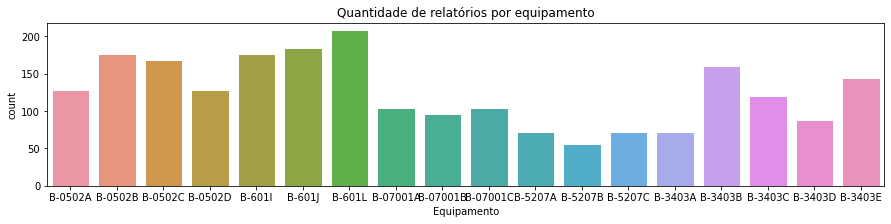

In [ ]:
plt.figure(figsize = (15,3)) # Label Count
plt.title('Quantidade de relatórios por equipamento')
sns.set_style("darkgrid")
sns.countplot(d_spec.df_vib['Equipamento'])

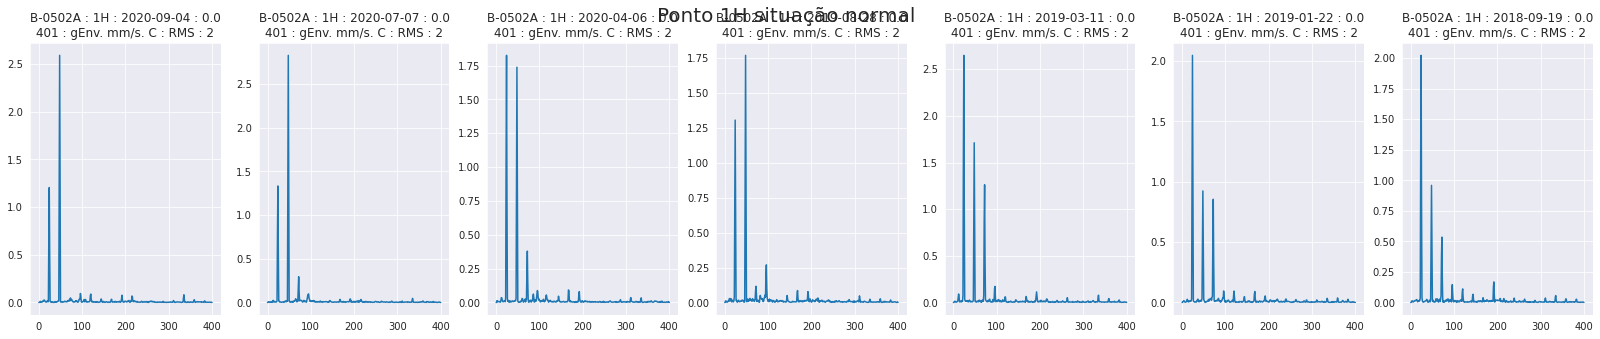

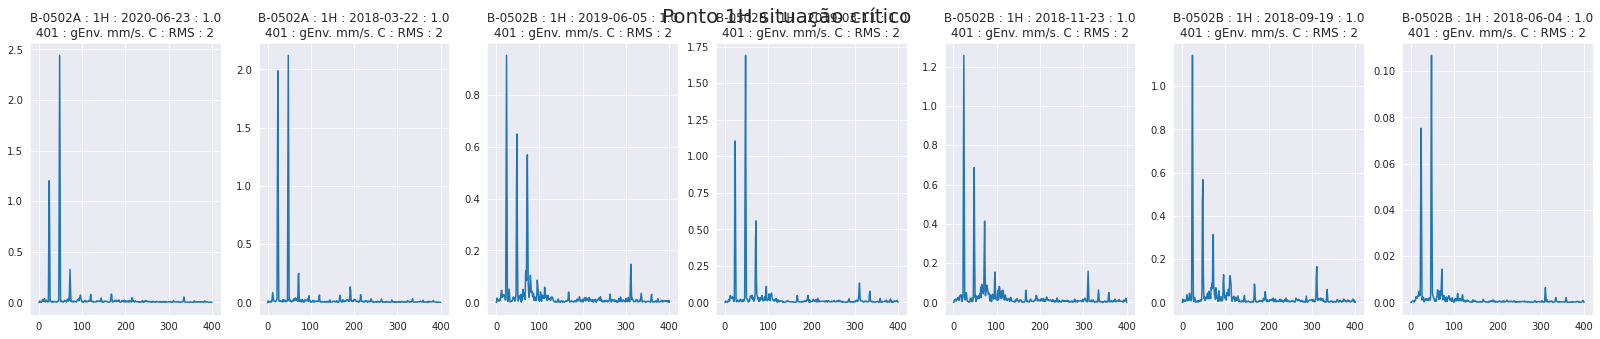

In [ ]:
n=7
cols = list(range(0,n_dados))
cols = [str(i) for i in cols]
df_vib2 = d_spec.df_vib[d_spec.df_vib['Ponto']=='1H']

fig, axs = plt.subplots(1, n, figsize=(28,5))
fig.suptitle('Ponto 1H situação normal', fontsize=20)
for j in range(n):
    row = df_vib2[df_vib2['Situacao']==0].iloc[j,:]
    axs[j].set_title('{} : {} : {} : {}\n{} : {} : {} : {}'.format(row['Equipamento'], row['Ponto'], row['Data'], row['Situacao'], row['Linhas'], row['Unidade'], row['Deteccao'], row['Canal']))
    axs[j].plot(row[cols].values.reshape(n_dados))

fig, axs = plt.subplots(1, n, figsize=(28,5))
fig.suptitle('Ponto 1H situação crítico', fontsize=20)
for j in range(n):
    row = df_vib2[df_vib2['Situacao']==1].iloc[j,:]
    axs[j].set_title('{} : {} : {} : {}\n{} : {} : {} : {}'.format(row['Equipamento'], row['Ponto'], row['Data'], row['Situacao'], row['Linhas'], row['Unidade'], row['Deteccao'], row['Canal']))
    axs[j].plot(row[cols].values.reshape(n_dados))

Reorganiza criando terceira dimensao (relatorio) com as medicoes de cada equipamento/data.

Exemplo: 8 pontos ['1H','1V','2H','2V','3H','3V','4H','4V'] vezes 1 canal = 8 linhas por equipamento

In [ ]:
d_spec.DfArray()
print('df_array.shape: ', d_spec.df_array.shape)
print("df_array['x'][0].shape: ", d_spec.df_array['x'][0].shape)

df_array.shape:  (282, 2)
df_array['x'][0].shape:  (8, 401, 1)


205 normais e 77 críticos


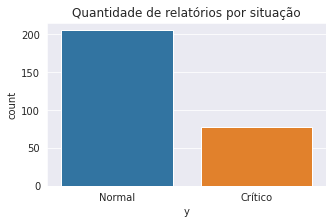

In [ ]:
plt.figure(figsize = (5,3)) # Label Count
plt.title('Quantidade de relatórios por situação')
sns.set_style("darkgrid")
sns.countplot(d_spec.df_array['y'].replace({0:'Normal', 1:'Crítico'}))
n_normais = len(d_spec.df_array[d_spec.df_array['y']==0])
n_criticos = len(d_spec.df_array[d_spec.df_array['y']==1])
print('{} normais e {} críticos'.format(n_normais,n_criticos))

In [ ]:
d_spec.Oversample()

Antes: 205 normais e 77 criticos
Depois: 205 normais e 205 criticos


205 normais e 205 críticos


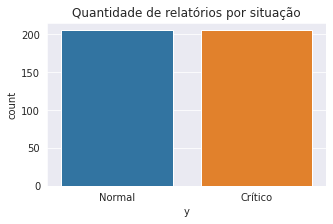

In [ ]:
plt.figure(figsize = (5,3)) # Label Count
plt.title('Quantidade de relatórios por situação')
sns.set_style("darkgrid")
sns.countplot(d_spec.df_array['y'].replace({0:'Normal', 1:'Crítico'}))
n_normais = len(d_spec.df_array[d_spec.df_array['y']==0])
n_criticos = len(d_spec.df_array[d_spec.df_array['y']==1])
print('{} normais e {} críticos'.format(n_normais,n_criticos))

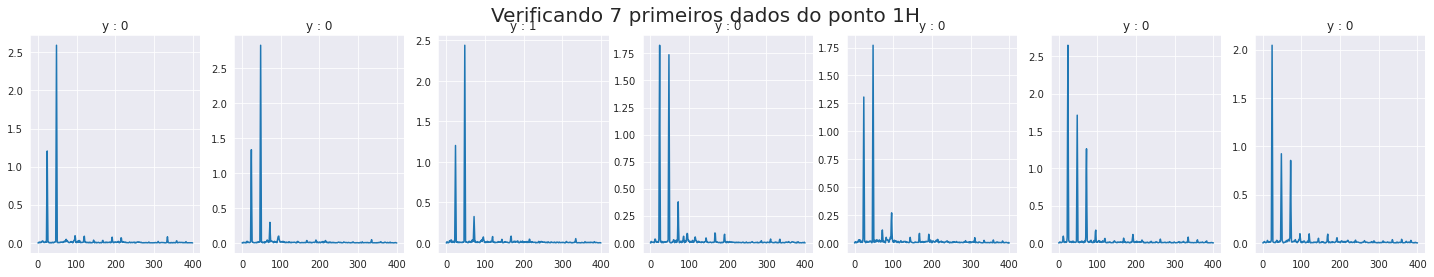

In [ ]:
fig, axs = plt.subplots(1, 7, figsize=(25,4))
fig.suptitle('Verificando 7 primeiros dados do ponto 1H', fontsize=20)
for j in range(7):
  row = d_spec.df_array.iloc[j,:]
  axs[j].set_title(f"y : {row['y']}")
  axs[j].plot(row['x'].reshape(-1,d_spec.n_dados)[0,:])

In [ ]:
d_spec.df_array['x'].values[0][0][d_spec.n_dados-10:d_spec.n_dados]

array([[0.002215],
       [0.002215],
       [0.001187],
       [0.001978],
       [0.001424],
       [0.002057],
       [0.003323],
       [0.002215],
       [0.000633],
       [0.      ]])

In [ ]:
d_spec.df_array['x'].values.shape

(410,)

In [ ]:
d_spec.Array()
print('x_array.shape: ', d_spec.x_array.shape)
print('y_array.shape: ', d_spec.y_array.shape)

x_array.shape:  (410, 8, 401, 1)
y_array.shape:  (410,)


In [ ]:
d_spec.x_array[0][0][d_spec.n_dados-10:d_spec.n_dados]

array([[0.002215],
       [0.002215],
       [0.001187],
       [0.001978],
       [0.001424],
       [0.002057],
       [0.003323],
       [0.002215],
       [0.000633],
       [0.      ]])

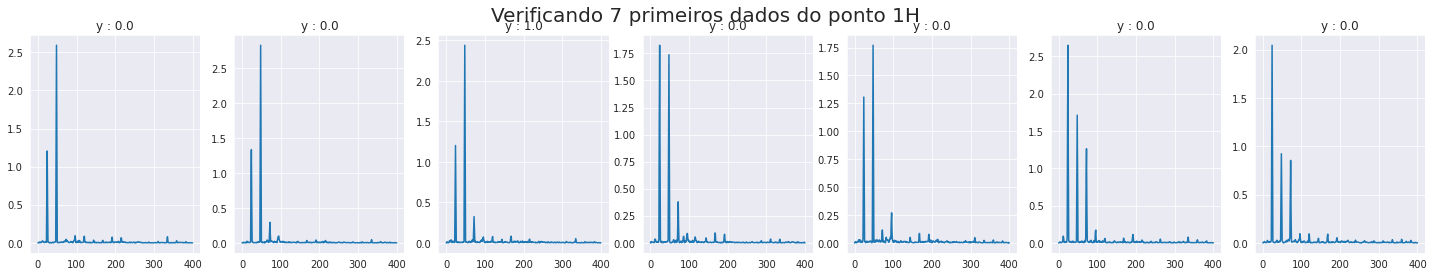

In [ ]:
fig, axs = plt.subplots(1, 7, figsize=(25,4))
fig.suptitle('Verificando 7 primeiros dados do ponto 1H', fontsize=20)
for j in range(7):
  axs[j].set_title(f"y : {d_spec.y_array[j]}")
  axs[j].plot(d_spec.x_array[j,0,:,:].reshape(-1))

In [ ]:
d_spec.Split(test_size=0.2, random_state=0)
d_spec.x_train.shape

(328, 8, 401, 1)

## Rede Convolucional

In [ ]:
# rede convolucional com os maximos ajustados antes, consegui 0.92 de acuracia na validacao
model_cnn_spec_400 = Sequential()

model_cnn_spec_400.add(Conv2D(30 , (1,5) , strides = 1 , padding='valid' , activation='relu' , dilation_rate=1, input_shape=(d_spec.n_pontos,d_spec.n_dados,1)))
model_cnn_spec_400.add(BatchNormalization())
model_cnn_spec_400.add(MaxPool2D((1,2) , strides = (1,2) , padding = 'valid'))

model_cnn_spec_400.add(Flatten())

model_cnn_spec_400.add(Dense(units = 300 , activation = 'relu'))
model_cnn_spec_400.add(Dense(units = 50 , activation = 'relu'))
model_cnn_spec_400.add(Dense(units = 1 , activation = 'sigmoid'))

opt = optimizers.Adam()
#opt = optimizers.Adadelta()
model_cnn_spec_400.compile(optimizer = opt , loss = 'binary_crossentropy' , metrics = ['binary_accuracy'])
model_cnn_spec_400.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 8, 397, 30)        180       
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 397, 30)        120       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 198, 30)        0         
_________________________________________________________________
flatten (Flatten)            (None, 47520)             0         
_________________________________________________________________
dense (Dense)                (None, 300)               14256300  
_________________________________________________________________
dense_1 (Dense)              (None, 50)                15050     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_binary_accuracy', patience = 10, verbose=1,factor=0.75, min_lr=1)
history = model_cnn_spec_400.fit(d_spec.x_train, d_spec.y_train, batch_size = 15, epochs = 100 , validation_data = (d_spec.x_test, d_spec.y_test) , callbacks = [learning_rate_reduction])

Epoch 1/100
22/22 [==============================] - 32s 30ms/step - loss: 1.0073 - binary_accuracy: 0.7378 - val_loss: 1.4204 - val_binary_accuracy: 0.4390
Epoch 2/100
22/22 [==============================] - 0s 16ms/step - loss: 0.2838 - binary_accuracy: 0.8659 - val_loss: 1.5726 - val_binary_accuracy: 0.4390
Epoch 3/100
22/22 [==============================] - 0s 15ms/step - loss: 0.2676 - binary_accuracy: 0.8780 - val_loss: 1.4383 - val_binary_accuracy: 0.4390
Epoch 4/100
22/22 [==============================] - 0s 17ms/step - loss: 0.1084 - binary_accuracy: 0.9665 - val_loss: 1.4550 - val_binary_accuracy: 0.4390
Epoch 5/100
22/22 [==============================] - 0s 17ms/step - loss: 0.0281 - binary_accuracy: 1.0000 - val_loss: 1.2044 - val_binary_accuracy: 0.4390
Epoch 6/100
22/22 [==============================] - 0s 15ms/step - loss: 0.0143 - binary_accuracy: 1.0000 - val_loss: 0.9048 - val_binary_accuracy: 0.5610
Epoch 7/100
22/22 [==============================] - 0s 15ms/st

Text(0.5, 1.0, 'val_binary_accuracy')

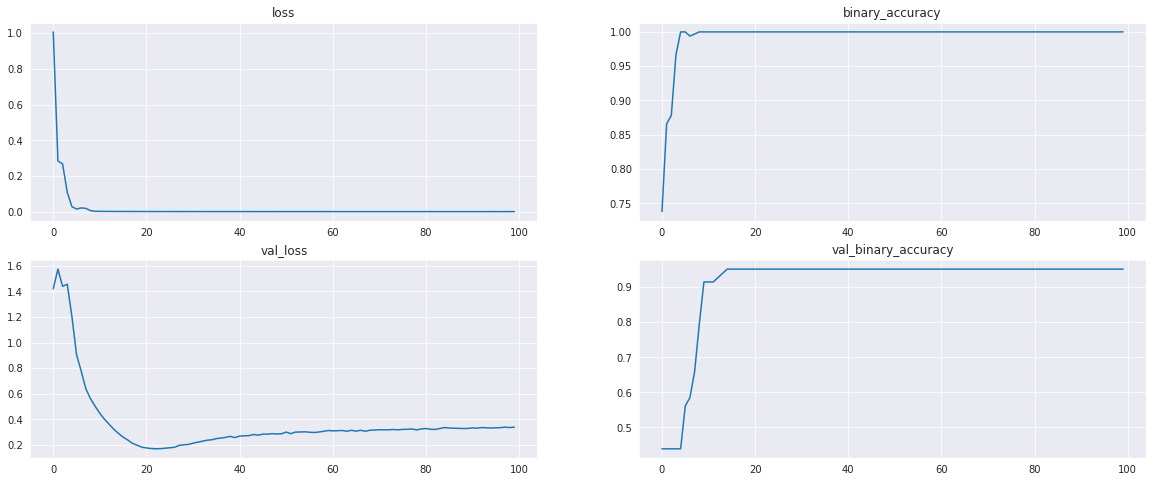

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(20,8))
axs[0, 0].plot(history.history['loss'])
axs[0, 0].set_title('loss')
axs[0, 1].plot(history.history['binary_accuracy'])
axs[0, 1].set_title('binary_accuracy')
axs[1, 0].plot(history.history['val_loss'])
axs[1, 0].set_title('val_loss')
axs[1, 1].plot(history.history['val_binary_accuracy'])
axs[1, 1].set_title('val_binary_accuracy')

In [ ]:
y_pred = model_cnn_spec_400.predict(d_spec.x_test)
y_pred = np.where(y_pred > 0.5, 1,0)

In [ ]:
cm = confusion_matrix(d_spec.y_test,y_pred)
cm

array([[42,  4],
       [ 0, 36]])

In [ ]:
# normalizando
#x_train = x_train/np.max(x_train)
#np.max(x_train)

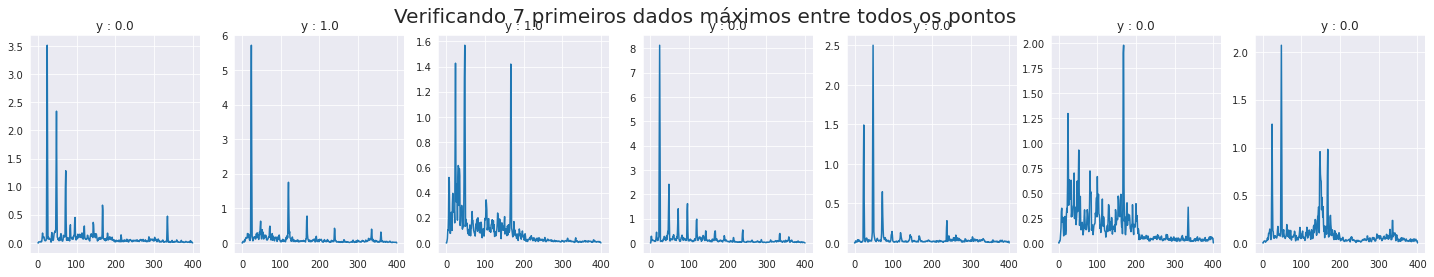

In [ ]:
fig, axs = plt.subplots(1, 7, figsize=(25,4))
fig.suptitle('Verificando 7 primeiros dados máximos entre todos os pontos', fontsize=20)
for j in range(7):
  axs[j].set_title(f"y : {d_spec.y_train[j]}")
  axs[j].plot(d_spec.x_train_max[j,:,:,:].reshape(-1))

In [ ]:
# rede convolucional com os maximos ajustados antes, consegui 0.92 de acuracia na validacao
model_cnn_spec_400_max = Sequential()

model_cnn_spec_400_max.add(Conv2D(30 , (1,5) , strides = 1 , padding='valid' , activation='relu' , dilation_rate=1, input_shape=(1,d_spec.n_dados,1)))
model_cnn_spec_400_max.add(BatchNormalization())
model_cnn_spec_400_max.add(MaxPool2D((1,2) , strides = (1,2) , padding = 'valid'))

model_cnn_spec_400_max.add(Flatten())

model_cnn_spec_400_max.add(Dense(units = 300 , activation = 'relu'))
model_cnn_spec_400_max.add(Dense(units = 50 , activation = 'relu'))
model_cnn_spec_400_max.add(Dense(units = 1 , activation = 'sigmoid'))

opt = optimizers.Adam()
#opt = optimizers.Adadelta()
model_cnn_spec_400_max.compile(optimizer = opt , loss = 'binary_crossentropy' , metrics = ['binary_accuracy'])
model_cnn_spec_400_max.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 397, 30)        180       
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 397, 30)        120       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 198, 30)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5940)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               1782300   
_________________________________________________________________
dense_4 (Dense)              (None, 50)                15050     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_binary_accuracy', patience = 10, verbose=1,factor=0.75, min_lr=1)
history = model_cnn_spec_400_max.fit(d_spec.x_train_max,d_spec.y_train, batch_size = 15, epochs = 100 , validation_data = (d_spec.x_test_max, d_spec.y_test) , callbacks = [learning_rate_reduction])

Epoch 1/100
22/22 [==============================] - 1s 15ms/step - loss: 0.6435 - binary_accuracy: 0.6982 - val_loss: 0.7073 - val_binary_accuracy: 0.4390
Epoch 2/100
22/22 [==============================] - 0s 7ms/step - loss: 0.4223 - binary_accuracy: 0.8110 - val_loss: 0.6717 - val_binary_accuracy: 0.4512
Epoch 3/100
22/22 [==============================] - 0s 7ms/step - loss: 0.3063 - binary_accuracy: 0.8476 - val_loss: 0.6859 - val_binary_accuracy: 0.4390
Epoch 4/100
22/22 [==============================] - 0s 8ms/step - loss: 0.2071 - binary_accuracy: 0.9055 - val_loss: 0.6657 - val_binary_accuracy: 0.4634
Epoch 5/100
22/22 [==============================] - 0s 7ms/step - loss: 0.1803 - binary_accuracy: 0.9390 - val_loss: 0.6560 - val_binary_accuracy: 0.5122
Epoch 6/100
22/22 [==============================] - 0s 7ms/step - loss: 0.1675 - binary_accuracy: 0.9268 - val_loss: 0.6188 - val_binary_accuracy: 0.6463
Epoch 7/100
22/22 [==============================] - 0s 7ms/step - lo

Text(0.5, 1.0, 'val_binary_accuracy')

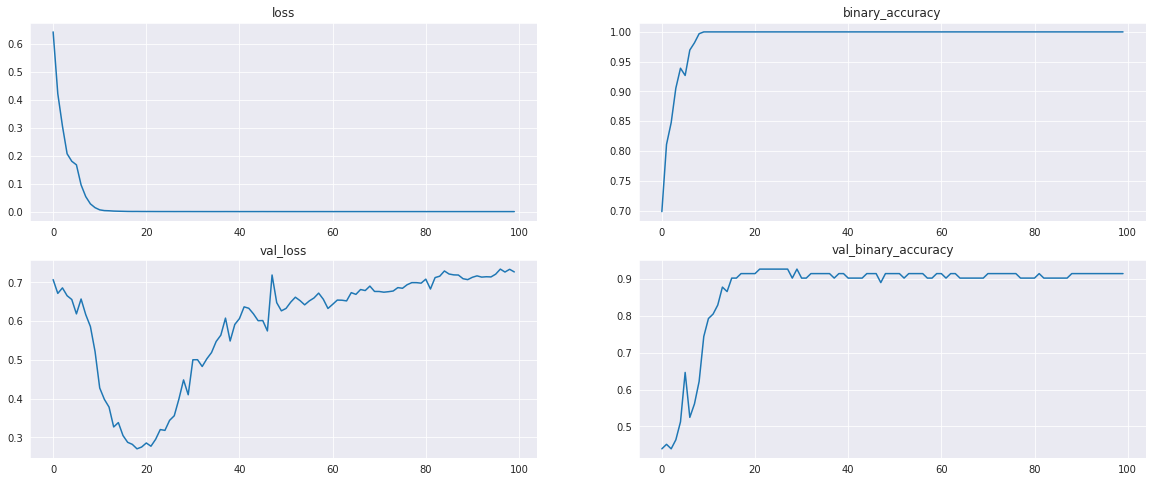

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(20,8))
axs[0, 0].plot(history.history['loss'])
axs[0, 0].set_title('loss')
axs[0, 1].plot(history.history['binary_accuracy'])
axs[0, 1].set_title('binary_accuracy')
axs[1, 0].plot(history.history['val_loss'])
axs[1, 0].set_title('val_loss')
axs[1, 1].plot(history.history['val_binary_accuracy'])
axs[1, 1].set_title('val_binary_accuracy')

In [ ]:
#predictions = model.predict_classes(d_spec.x_test_max)
y_pred = model_cnn_spec_400_max.predict(d_spec.x_test_max)
y_pred = np.where(y_pred > 0.5, 1,0)

In [ ]:
cm = confusion_matrix(d_spec.y_test,y_pred)
cm

array([[39,  7],
       [ 0, 36]])

## Rede Dense

In [ ]:
model_dense_spec_400 = Sequential()

model_dense_spec_400.add(Flatten(input_shape=(d_spec.n_pontos,d_spec.n_dados,1)))

model_dense_spec_400.add(Dense(units = 300 , activation = 'relu'))
model_dense_spec_400.add(Dense(units = 50 , activation = 'relu'))
model_dense_spec_400.add(Dense(units = 1 , activation = 'sigmoid'))

opt = optimizers.Adam()
#opt = optimizers.Adadelta()
model_dense_spec_400.compile(optimizer = opt , loss = 'binary_crossentropy' , metrics = ['binary_accuracy'])
model_dense_spec_400.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 3208)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 300)               962700    
_________________________________________________________________
dense_10 (Dense)             (None, 50)                15050     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 51        
Total params: 977,801
Trainable params: 977,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_binary_accuracy', patience = 10, verbose=1,factor=0.75, min_lr=1)
history = model_dense_spec_400.fit(d_spec.x_train,d_spec.y_train, batch_size = 15 ,epochs = 100 , validation_data = (d_spec.x_test, d_spec.y_test) , callbacks = [learning_rate_reduction])

Epoch 1/100
22/22 [==============================] - 1s 11ms/step - loss: 0.5728 - binary_accuracy: 0.6982 - val_loss: 0.5327 - val_binary_accuracy: 0.7927
Epoch 2/100
22/22 [==============================] - 0s 5ms/step - loss: 0.4593 - binary_accuracy: 0.8140 - val_loss: 0.5707 - val_binary_accuracy: 0.7439
Epoch 3/100
22/22 [==============================] - 0s 5ms/step - loss: 0.3752 - binary_accuracy: 0.8171 - val_loss: 0.4222 - val_binary_accuracy: 0.8415
Epoch 4/100
22/22 [==============================] - 0s 5ms/step - loss: 0.2831 - binary_accuracy: 0.8963 - val_loss: 0.3336 - val_binary_accuracy: 0.8902
Epoch 5/100
22/22 [==============================] - 0s 5ms/step - loss: 0.1752 - binary_accuracy: 0.9451 - val_loss: 0.3984 - val_binary_accuracy: 0.8415
Epoch 6/100
22/22 [==============================] - 0s 6ms/step - loss: 0.1892 - binary_accuracy: 0.9299 - val_loss: 0.2532 - val_binary_accuracy: 0.9268
Epoch 7/100
22/22 [==============================] - 0s 5ms/step - lo

Text(0.5, 1.0, 'val_binary_accuracy')

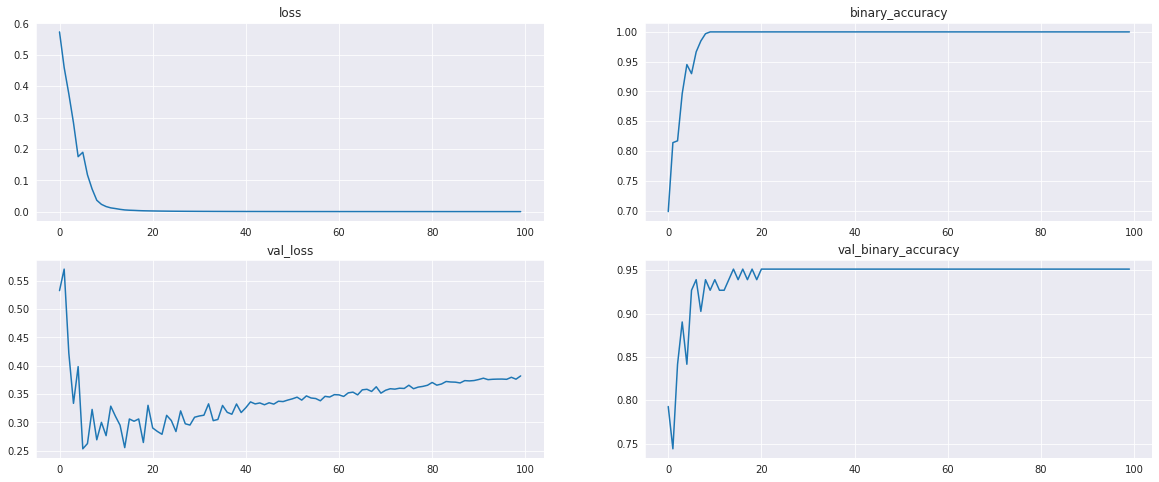

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(20,8))
axs[0, 0].plot(history.history['loss'])
axs[0, 0].set_title('loss')
axs[0, 1].plot(history.history['binary_accuracy'])
axs[0, 1].set_title('binary_accuracy')
axs[1, 0].plot(history.history['val_loss'])
axs[1, 0].set_title('val_loss')
axs[1, 1].plot(history.history['val_binary_accuracy'])
axs[1, 1].set_title('val_binary_accuracy')

In [ ]:
y_pred = model_dense_spec_400.predict(d_spec.x_test)
y_pred = np.where(y_pred > 0.5, 1,0)
cm = confusion_matrix(d_spec.y_test,y_pred)
cm

array([[42,  4],
       [ 0, 36]])

# **Spectro 801 pontos (envelope)**

## Carrega dados

In [ ]:
tipo = 'Spectra'
canais = [1]
linhas = [801]  #coluna Linhas      pegando apenas grafico de velocidade
n_dados = 801  #posso pegar menos dados para o cepstrum por exemplo
n_pontos = int(len(pontos))

d_spec800 = leitura.Dados(arq_vib, instalacoes=instalacoes, tipo=tipo, pontos=pontos, linhas=linhas, canais=canais, n_dados=n_dados)
d_spec800.Carrega()
d_spec800.df_vib.head()

Itarare
(1540, 3213)
TEFRAN
(1020, 6413)
TEDUT
(1420, 813)
ESPAT
(760, 813)
Itajai
(400, 813)
TEPAR
(1168, 813)
df_vib.shape:  (2256, 813)
Numero de relatorios:  282


,Situacao,Data,Instalacao,Equipamento,Ponto,Nome,Unidade,Deteccao,Canal,Linhas,Frequencia Final,Velocidade,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,...,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800
0,0.0,2020-09-04,Itarare,B-0502A,1H,\Hierarquia\REPAR\ITARARÉ\Bombas Principais\B-...,gEnv. mm/s. C,RMS,1,801,2000000,60.0,0.0,0.0,0.006995,0.006622,0.009100,0.008231,0.011266,0.010648,0.007858,0.008482,0.008604,0.003648,0.005508,0.008727,0.010275,0.007117,0.006622,0.005258,0.004701,0.004455,0.004021,0.003587,0.011389,0.064822,0.097696,0.048227,0.009161,0.004951,...,0.004517,0.004205,0.007117,0.007986,0.019870,0.019068,0.009038,0.007429,0.006003,0.005508,0.006438,0.005196,0.003464,0.002907,0.004828,0.004271,0.004082,0.001916,0.002596,0.004701,0.003403,0.002166,0.001977,0.001609,0.002969,0.003342,0.003960,0.016713,0.040241,0.024331,0.007429,0.006560,0.005135,0.003898,0.001916,0.001855,0.004205,0.006003,0.004578,0.0
2,0.0,2020-09-04,Itarare,B-0502A,1V,\Hierarquia\REPAR\ITARARÉ\Bombas Principais\B-...,gEnv. mm/s. C,RMS,1,801,2000000,60.0,0.0,0.0,0.017767,0.007980,0.007673,0.009595,0.010768,0.006990,0.004827,0.006066,0.002596,0.003096,0.007489,0.010152,0.002904,0.001789,0.006250,0.007298,0.006125,0.007240,0.007673,0.008480,0.003528,0.105493,0.194343,0.089707,0.010519,0.003645,...,0.003587,0.003587,0.008105,0.011883,0.026679,0.030024,0.012499,0.004702,0.004144,0.004951,0.005567,0.005010,0.003462,0.004269,0.003770,0.005318,0.007922,0.010152,0.006865,0.002288,0.008413,0.006682,0.005817,0.004827,0.002222,0.004577,0.004144,0.009836,0.029650,0.030707,0.008480,0.005509,0.003836,0.004702,0.003587,0.004643,0.003212,0.003462,0.003528,0.0
6,0.0,2020-09-04,Itarare,B-0502A,2H,\Hierarquia\REPAR\ITARARÉ\Bombas Principais\B-...,gEnv. mm/s. C,RMS,1,801,2000000,60.0,0.0,0.0,0.013806,0.021606,0.010461,0.012939,0.022660,0.016654,0.020862,0.015970,0.016654,0.018694,0.019192,0.017024,0.016777,0.013555,0.017394,0.012072,0.006436,0.014673,0.008047,0.009160,0.021976,0.073055,0.098750,0.047360,0.020246,0.024577,...,0.009470,0.008544,0.007366,0.010274,0.016220,0.017644,0.008357,0.008914,0.011515,0.007426,0.007553,0.005445,0.008603,0.007056,0.002661,0.008170,0.010091,0.006129,0.013249,0.012072,0.006499,0.010274,0.008170,0.008544,0.004208,0.008850,0.006253,0.007613,0.026681,0.032317,0.013496,0.008416,0.004272,0.004085,0.006992,0.009904,0.009717,0.008603,0.005199,0.0
8,0.0,2020-09-04,Itarare,B-0502A,2V,\Hierarquia\REPAR\ITARARÉ\Bombas Principais\B-...,gEnv. mm/s. C,RMS,1,801,2000000,60.0,0.0,0.0,0.039624,0.049901,0.045877,0.028603,0.018262,0.038013,0.031885,0.025941,0.036463,0.029407,0.026684,0.035351,0.040242,0.026993,0.029901,0.027117,0.026869,0.022535,0.058568,0.058938,0.034608,0.066492,0.067360,0.037516,0.031636,0.039499,...,0.021419,0.030025,0.038817,0.037395,0.059681,0.039624,0.017768,0.013125,0.029407,0.020740,0.014238,0.020242,0.026065,0.019314,0.022041,0.025692,0.017828,0.021977,0.024824,0.028539,0.029407,0.015599,0.012503,0.015354,0.020057,0.015354,0.020491,0.037206,0.059187,0.037580,0.013495,0.014053,0.017892,0.008543,0.019997,0.015973,0.011390,0.009346,0.011450,0.0
12,0.0,2020-09-04,Itarare,B-0502A,3H,\Hierarquia\REPAR\ITARARÉ\Bombas Principais\B-...,gEnv. mm/s. C,RMS,1,801,2000000,60.0,0.0,0.0,0.092865,0.075152,0.125172,0.109327,0.100657,0.113548,0.104132,0.083205,0.098563,0.083822,0.083578,0.151424,0.168276,0.108580,0.103012,0.148827,0.120967,0.161344,0.131244,0.108580,0.029337,0.104002,0.070947,0.060297,0.085559,0.074665,...,0.007549,0.012371,0.017696,0.012501,0.016219,0.021544,0.011267,0.014108,0.011884,0.012874,0.020294,0.015342,0.011007,0.007793,0.008166,0.010017,0.012988,0.010390,0.014969,0.010390,0.007923,0.009027,0.010147,0.009400,0.010277,0.009157,0.012371,0.015602,0.020294,0.027729,0.023525,0.015342,0.013491,0.025749,0.022778,0.004075,0.010017,0.015602,0.013978,0.0


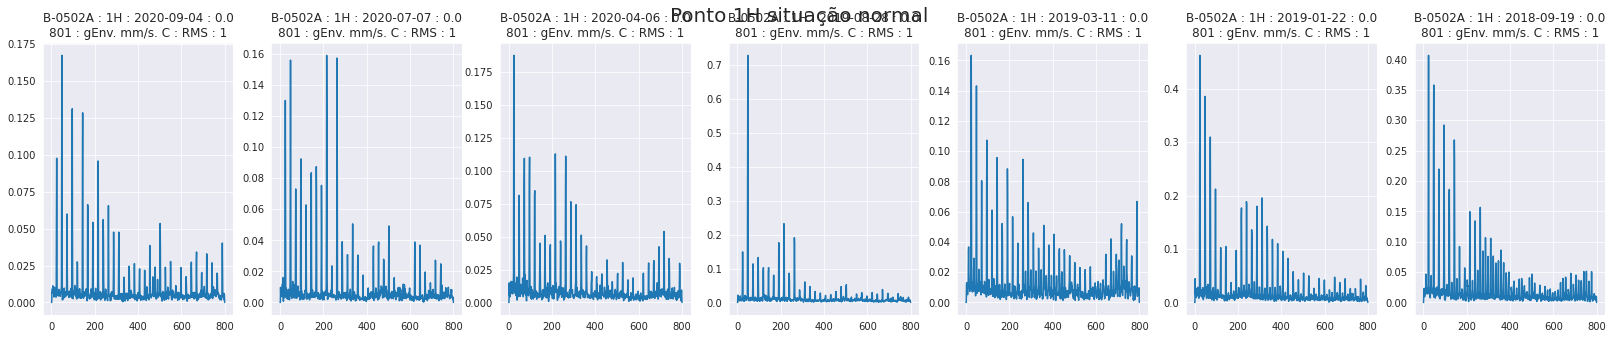

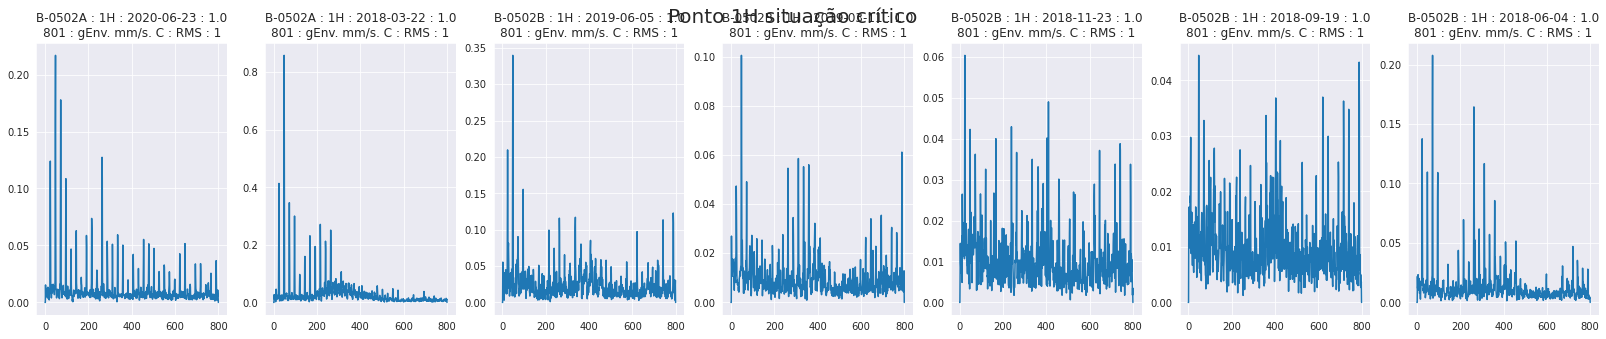

In [ ]:
n=7
cols = list(range(0,n_dados))
cols = [str(i) for i in cols]
df_vib2 = d_spec800.df_vib[d_spec800.df_vib['Ponto']=='1H']

fig, axs = plt.subplots(1, n, figsize=(28,5))
fig.suptitle('Ponto 1H situação normal', fontsize=20)
for j in range(n):
    row = df_vib2[df_vib2['Situacao']==0].iloc[j,:]
    axs[j].set_title('{} : {} : {} : {}\n{} : {} : {} : {}'.format(row['Equipamento'], row['Ponto'], row['Data'], row['Situacao'], row['Linhas'], row['Unidade'], row['Deteccao'], row['Canal']))
    axs[j].plot(row[cols].values.reshape(n_dados))

fig, axs = plt.subplots(1, n, figsize=(28,5))
fig.suptitle('Ponto 1H situação crítico', fontsize=20)
for j in range(n):
    row = df_vib2[df_vib2['Situacao']==1].iloc[j,:]
    axs[j].set_title('{} : {} : {} : {}\n{} : {} : {} : {}'.format(row['Equipamento'], row['Ponto'], row['Data'], row['Situacao'], row['Linhas'], row['Unidade'], row['Deteccao'], row['Canal']))
    axs[j].plot(row[cols].values.reshape(n_dados))

In [ ]:
d_spec800.DfArray()
print('df_array.shape: ', d_spec800.df_array.shape)
print("df_array['x'][0].shape: ", d_spec800.df_array['x'][0].shape)

df_array.shape:  (282, 2)
df_array['x'][0].shape:  (8, 801, 1)


205 normais e 77 críticos


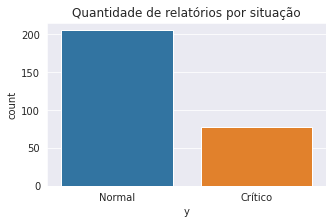

In [ ]:
plt.figure(figsize = (5,3)) # Label Count
plt.title('Quantidade de relatórios por situação')
sns.set_style("darkgrid")
sns.countplot(d_spec800.df_array['y'].replace({0:'Normal', 1:'Crítico'}))
n_normais = len(d_spec800.df_array[d_spec800.df_array['y']==0])
n_criticos = len(d_spec800.df_array[d_spec800.df_array['y']==1])
print('{} normais e {} críticos'.format(n_normais,n_criticos))

In [ ]:
d_spec800.Oversample()

Antes: 205 normais e 77 criticos
Depois: 205 normais e 205 criticos


205 normais e 205 críticos


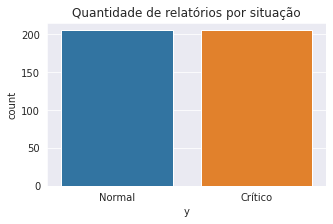

In [ ]:
plt.figure(figsize = (5,3)) # Label Count
plt.title('Quantidade de relatórios por situação')
sns.set_style("darkgrid")
sns.countplot(d_spec800.df_array['y'].replace({0:'Normal', 1:'Crítico'}))
n_normais = len(d_spec800.df_array[d_spec800.df_array['y']==0])
n_criticos = len(d_spec800.df_array[d_spec800.df_array['y']==1])
print('{} normais e {} críticos'.format(n_normais,n_criticos))

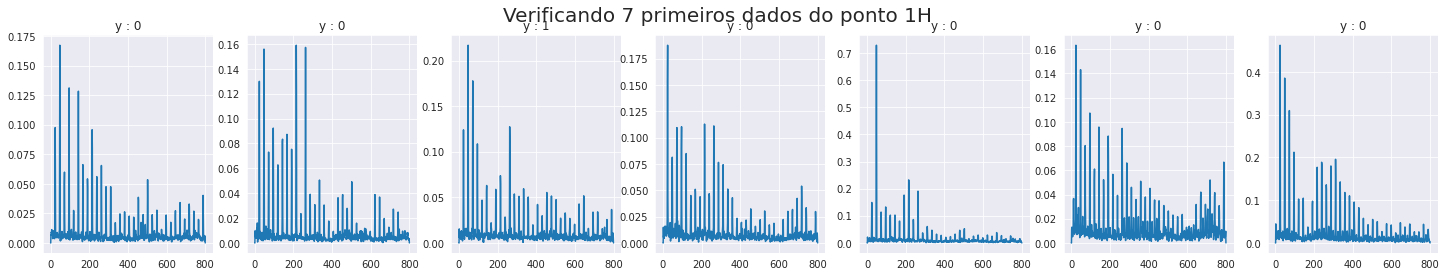

In [ ]:
fig, axs = plt.subplots(1, 7, figsize=(25,4))
fig.suptitle('Verificando 7 primeiros dados do ponto 1H', fontsize=20)
for j in range(7):
  row = d_spec800.df_array.iloc[j,:]
  axs[j].set_title(f"y : {row['y']}")
  axs[j].plot(row['x'].reshape(-1,d_spec800.n_dados)[0,:])

In [ ]:
d_spec800.df_array['x'].values[0][0][d_spec800.n_dados-10:d_spec800.n_dados]

array([[0.007429],
       [0.00656 ],
       [0.005135],
       [0.003898],
       [0.001916],
       [0.001855],
       [0.004205],
       [0.006003],
       [0.004578],
       [0.      ]])

In [ ]:
d_spec800.df_array['x'].values.shape

(410,)

In [ ]:
d_spec800.Array()
print('x_array.shape: ', d_spec800.x_array.shape)
print('y_array.shape: ', d_spec800.y_array.shape)

x_array.shape:  (410, 8, 801, 1)
y_array.shape:  (410,)


In [ ]:
d_spec800.x_array[0][0][d_spec800.n_dados-10:d_spec800.n_dados]

array([[0.007429],
       [0.00656 ],
       [0.005135],
       [0.003898],
       [0.001916],
       [0.001855],
       [0.004205],
       [0.006003],
       [0.004578],
       [0.      ]])

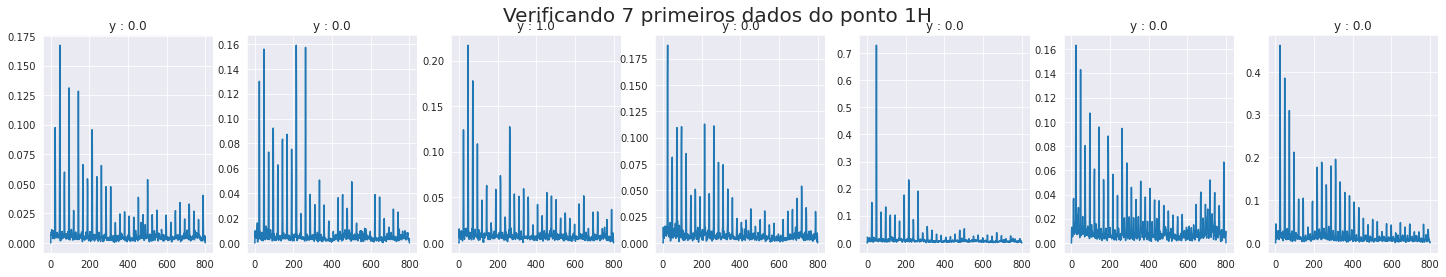

In [ ]:
fig, axs = plt.subplots(1, 7, figsize=(25,4))
fig.suptitle('Verificando 7 primeiros dados do ponto 1H', fontsize=20)
for j in range(7):
  axs[j].set_title(f"y : {d_spec800.y_array[j]}")
  axs[j].plot(d_spec800.x_array[j,0,:,:].reshape(-1))

In [ ]:
d_spec800.Split(test_size=0.2, random_state=0)
d_spec800.x_train.shape

(328, 8, 801, 1)

## Rede Convolucional

In [ ]:
# rede convolucional com os maximos ajustados antes, consegui 0.92 de acuracia na validacao
model_cnn_spec_800 = Sequential()

model_cnn_spec_800.add(Conv2D(30 , (1,5) , strides = 1 , padding='valid' , activation='relu' , dilation_rate=1, input_shape=(d_spec800.n_pontos,d_spec800.n_dados,1)))
model_cnn_spec_800.add(BatchNormalization())
model_cnn_spec_800.add(MaxPool2D((1,2) , strides = (1,2) , padding = 'valid'))

model_cnn_spec_800.add(Flatten())

model_cnn_spec_800.add(Dense(units = 300 , activation = 'relu'))
model_cnn_spec_800.add(Dense(units = 50 , activation = 'relu'))
model_cnn_spec_800.add(Dense(units = 1 , activation = 'sigmoid'))

opt = optimizers.Adam()
#opt = optimizers.Adadelta()
model_cnn_spec_800.compile(optimizer = opt , loss = 'binary_crossentropy' , metrics = ['binary_accuracy'])
model_cnn_spec_800.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 8, 797, 30)        180       
_________________________________________________________________
batch_normalization_3 (Batch (None, 8, 797, 30)        120       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 398, 30)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 95520)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 300)               28656300  
_________________________________________________________________
dense_13 (Dense)             (None, 50)                15050     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_binary_accuracy', patience = 10, verbose=1,factor=0.75, min_lr=1)
history = model_cnn_spec_800.fit(d_spec800.x_train, d_spec800.y_train, batch_size = 10, epochs = 100 , validation_data = (d_spec800.x_test, d_spec800.y_test) , callbacks = [learning_rate_reduction])

Epoch 1/100
33/33 [==============================] - 2s 32ms/step - loss: 2.5004 - binary_accuracy: 0.6890 - val_loss: 0.8831 - val_binary_accuracy: 0.4390
Epoch 2/100
33/33 [==============================] - 1s 23ms/step - loss: 0.6095 - binary_accuracy: 0.7774 - val_loss: 0.7449 - val_binary_accuracy: 0.4512
Epoch 3/100
33/33 [==============================] - 1s 23ms/step - loss: 0.3130 - binary_accuracy: 0.8872 - val_loss: 0.5349 - val_binary_accuracy: 0.8049
Epoch 4/100
33/33 [==============================] - 1s 23ms/step - loss: 0.1347 - binary_accuracy: 0.9695 - val_loss: 0.5576 - val_binary_accuracy: 0.9146
Epoch 5/100
33/33 [==============================] - 1s 23ms/step - loss: 0.0644 - binary_accuracy: 0.9909 - val_loss: 0.5682 - val_binary_accuracy: 0.8902
Epoch 6/100
33/33 [==============================] - 1s 22ms/step - loss: 0.0314 - binary_accuracy: 0.9970 - val_loss: 0.5243 - val_binary_accuracy: 0.9390
Epoch 7/100
33/33 [==============================] - 1s 22ms/ste

Text(0.5, 1.0, 'val_binary_accuracy')

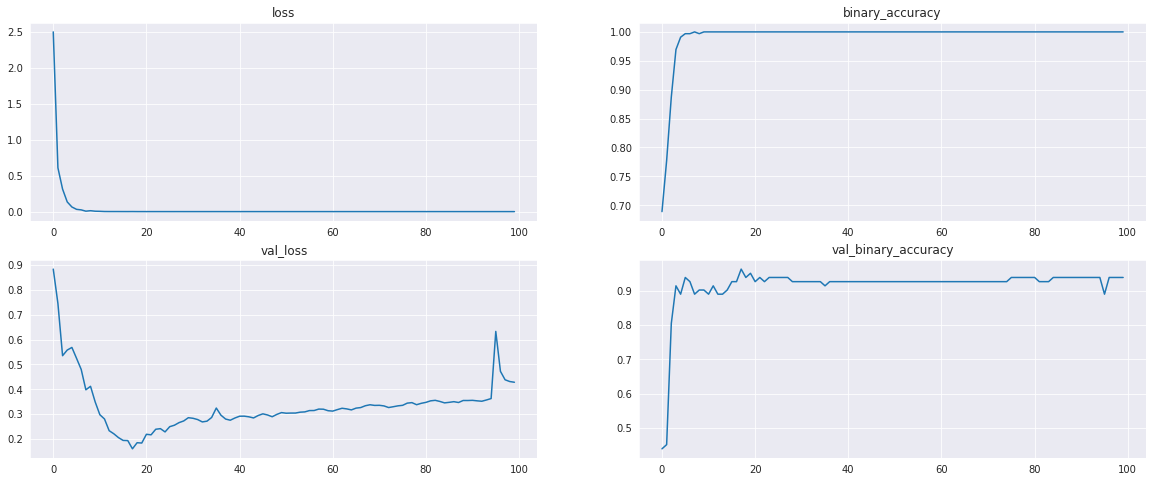

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(20,8))
axs[0, 0].plot(history.history['loss'])
axs[0, 0].set_title('loss')
axs[0, 1].plot(history.history['binary_accuracy'])
axs[0, 1].set_title('binary_accuracy')
axs[1, 0].plot(history.history['val_loss'])
axs[1, 0].set_title('val_loss')
axs[1, 1].plot(history.history['val_binary_accuracy'])
axs[1, 1].set_title('val_binary_accuracy')

In [ ]:
y_pred = model_cnn_spec_800.predict(d_spec800.x_test)
y_pred = np.where(y_pred > 0.5, 1,0)
cm = confusion_matrix(d_spec800.y_test,y_pred)
cm

array([[41,  5],
       [ 0, 36]])

## Rede Dense

In [ ]:
model_dense_spec_800 = Sequential()

model_dense_spec_800.add(Flatten(input_shape=(d_spec800.n_pontos,d_spec800.n_dados,1)))

model_dense_spec_800.add(Dense(units = 600 , activation = 'relu'))
model_dense_spec_800.add(Dense(units = 200 , activation = 'relu'))
model_dense_spec_800.add(Dense(units = 1 , activation = 'sigmoid'))

opt = optimizers.Adam()
#opt = optimizers.Adadelta()
model_dense_spec_800.compile(optimizer = opt , loss = 'binary_crossentropy' , metrics = ['binary_accuracy'])
model_dense_spec_800.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 6408)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 600)               3845400   
_________________________________________________________________
dense_16 (Dense)             (None, 200)               120200    
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 201       
Total params: 3,965,801
Trainable params: 3,965,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_binary_accuracy', patience = 10, verbose=1,factor=0.75, min_lr=1)
history = model_dense_spec_800.fit(d_spec800.x_train, d_spec800.y_train, batch_size = 10, epochs = 100 , validation_data = (d_spec800.x_test, d_spec800.y_test) , callbacks = [learning_rate_reduction])

Epoch 1/100
33/33 [==============================] - 1s 12ms/step - loss: 0.7364 - binary_accuracy: 0.5732 - val_loss: 0.7060 - val_binary_accuracy: 0.4390
Epoch 2/100
33/33 [==============================] - 0s 7ms/step - loss: 0.5649 - binary_accuracy: 0.7073 - val_loss: 0.5518 - val_binary_accuracy: 0.7683
Epoch 3/100
33/33 [==============================] - 0s 6ms/step - loss: 0.4596 - binary_accuracy: 0.8354 - val_loss: 0.4591 - val_binary_accuracy: 0.8293
Epoch 4/100
33/33 [==============================] - 0s 8ms/step - loss: 0.3881 - binary_accuracy: 0.8415 - val_loss: 0.3948 - val_binary_accuracy: 0.8902
Epoch 5/100
33/33 [==============================] - 0s 6ms/step - loss: 0.2808 - binary_accuracy: 0.8933 - val_loss: 0.3746 - val_binary_accuracy: 0.8780
Epoch 6/100
33/33 [==============================] - 0s 6ms/step - loss: 0.2025 - binary_accuracy: 0.9299 - val_loss: 0.2984 - val_binary_accuracy: 0.8902
Epoch 7/100
33/33 [==============================] - 0s 8ms/step - lo

Text(0.5, 1.0, 'val_binary_accuracy')

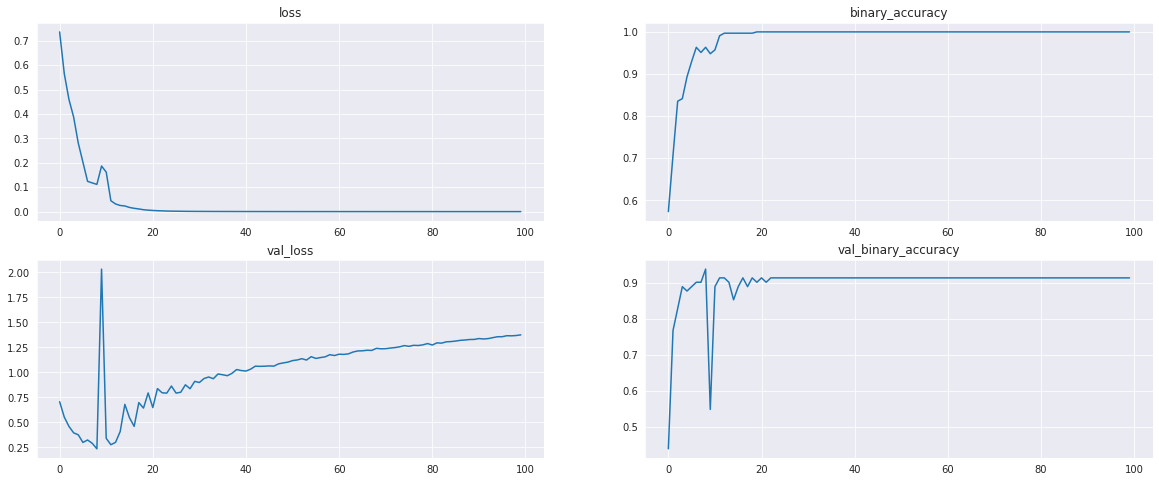

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(20,8))
axs[0, 0].plot(history.history['loss'])
axs[0, 0].set_title('loss')
axs[0, 1].plot(history.history['binary_accuracy'])
axs[0, 1].set_title('binary_accuracy')
axs[1, 0].plot(history.history['val_loss'])
axs[1, 0].set_title('val_loss')
axs[1, 1].plot(history.history['val_binary_accuracy'])
axs[1, 1].set_title('val_binary_accuracy')

In [ ]:
y_pred = model_dense_spec_800.predict(d_spec800.x_test)
y_pred = np.where(y_pred > 0.5, 1,0)
cm = confusion_matrix(d_spec800.y_test,y_pred)
cm

array([[39,  7],
       [ 0, 36]])